In [ ]:
'''   
Darcy: Super Resolution

'''
import os
import sys
sys.path.append("/home/user/Documents/GPO/general")
import gpytorch
from gpytorch.means import MultitaskMean
from gpytorch.kernels import InducingPointKernel, ScaleKernel
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utilities3 import *
from pytorch_wavelets import DWT, IDWT
from pytorch_wavelets import DWT1D, IDWT1D
import scipy
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle
from utils import *
from _sdd import *
from datetime import datetime
from pytorch_wavelets import DWTForward, DWTInverse
# %%
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f"Device: {device}")
# Disable cuDNN
# torch.backends.cudnn.enabled = False
current_time = datetime.now().strftime("%d%m%y_%H%M")

base_dir = '/home/user/Documents/GPO/experiments/C3_darcy_rect/results/'
torch.manual_seed(0)
np.random.seed(0)

# %%

ntrain = 1000
ntest = 200
# SDD parameters
lr = 0.01
momentum = 0.9
iterations = 20000
B = 4 #8
polyak=2e-3#1e-2
noise_scale=0.002
length_scale = 70 #2

step_size = 50
gamma = 0.75

level = 3 #4
width = 32  #64



r = 10 #15 # 5
h = int(((421 - 1)/r) + 1)
s = h

r1 = 15
r2 = 10
h1 = int(((421-1)/r1) + 1)
h2 = int(((421-1)/r2) + 1)
s1=h1
s2=h2


# %%
TRAIN_PATH = '/home/user/Documents/GP_WNO/DATA/piececonst_r421_N1024_smooth1.mat'
TEST_PATH = '/home/user/Documents/GP_WNO/DATA/piececonst_r421_N1024_smooth2.mat'

""" Read data """
reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r1,::r1][:,:s1,:s1]
y_train = reader.read_field('sol')[:ntrain,::r1,::r1][:,:s1,:s1]

y_train[:, 0, :] = 0
y_train[:, -1, :] = 0
y_train[:, :, 0] = 0
y_train[:, :, -1] = 0

#higher resolution
x_train_hres = reader.read_field('coeff')[:ntrain,::r2,::r2][:,:s2,:s2]
y_train_hres = reader.read_field('sol')[:ntrain,::r2,::r2][:,:s2,:s2]

y_train_hres[:, 0, :] = 0
y_train_hres[:, -1, :] = 0
y_train_hres[:, :, 0] = 0
y_train_hres[:, :, -1] = 0

reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r1,::r1][:,:s1,:s1]
y_test = reader.read_field('sol')[:ntest,::r1,::r1][:,:s1,:s1]

y_test[:, 0, :] = 0
y_test[:, -1, :] = 0
y_test[:, :, 0] = 0
y_test[:, :, -1] = 0

x_test_hres = reader.read_field('coeff')[:ntest,::r2,::r2][:,:s2,:s2]
y_test_hres = reader.read_field('sol')[:ntest,::r2,::r2][:,:s2,:s2]

y_test_hres[:, 0, :] = 0
y_test_hres[:, -1, :] = 0
y_test_hres[:, :, 0] = 0
y_test_hres[:, :, -1] = 0

#%%
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s1,s1,1)
x_test = x_test.reshape(ntest,s1,s1,1)

#high resoluion 
wp_x_t, wp_x_t_high_freq = wavelet_transform_reduction(x_test_hres.squeeze(-1), x_train.shape[1])
wp_y_t, wp_y_t_high_freq = wavelet_transform_reduction(y_test_hres, y_train.shape[1])

wp_x_train, wp_x_train_high_freq = wavelet_transform_reduction(x_train_hres.squeeze(-1), x_train.shape[1])
wp_y_train, wp_y_train_high_freq = wavelet_transform_reduction(y_test_hres, y_train.shape[1])


x_normalizer_hres = UnitGaussianNormalizer(wp_x_train)
wp_x_train = x_normalizer_hres.encode(wp_x_train)
wp_x_t = x_normalizer_hres.encode(wp_x_t)

y_normalizer_hres = UnitGaussianNormalizer(wp_y_train)
wp_y_train = y_normalizer_hres.encode(wp_y_train)
# y_test_hres = y_normalizer_hres.encode(wp_y_test_hres)

wp_x_train = wp_x_train.reshape(ntrain,s1,s1,1)
wp_x_t = wp_x_t.reshape(ntest,s1,s1,1)

x_t_hres = wp_x_t.reshape(wp_x_t.shape[0],-1).to(device=device)
y_t_hres = wp_y_t.reshape(wp_y_t.shape[0],-1).to(device=device)

# wp_x_train = wp_x_train.reshape(wp_x_train.shape[0],-1).to(device=device)
# wp_y_train = wp_y_train.reshape(wp_y_train.shape[0],-1).to(device=device)
# %%
""" Generating Grid and reshaping inputs """

# Grid 

grids = []
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

# train data
x_tr = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2],x_train.shape[3]).squeeze(-1)

y_tr = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])

# test data
x_t = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2],x_test.shape[3]).squeeze(-1)
y_t = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_test.shape[2])


x_tr=x_tr.to(device)
y_tr=y_tr.to(device)
x_t=x_t.to(device)
y_t=y_t.to(device)


Kernel = ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)).to(device=device)
Kernel.base_kernel.lengthscale= length_scale
#Load y_pred_sdd
# y_pred_sdd = torch.load("/home/user/Documents/DKL/Burger/model"+'y_pred_sdd.pt')
# y_pred_sdd = torch.load("/home/user/Documents/GPO/experiments/C5_navier/results/y_pred_sdd_hres_13_8.pt").to(device)
# nn_wno = WNO1d(width, level, x_train.permute(0,2,1)).to(device)


Device: cuda:0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Load the saved numpy arrays
base_dir = '/home/user/Documents/GPO/experiments/C3_darcy_rect/results/'
# current_time = 'your_saved_timestamp_here'  # Replace with the actual timestamp used when saving

SDD_mean_pred = np.load(f'{base_dir}SDD_sample_mean_predictions_100924_1841.npy')
SDD_std_pred = np.load(f'{base_dir}SDD_sample_variance_predictions_100924_1841.npy')
# SDD_sample_pred = np.load(f'{base_dir}hres_resultsSDD_sample_predictions_130824_1044.npy')
# Assuming resl, x_test, y_t, and x_axis are already defined


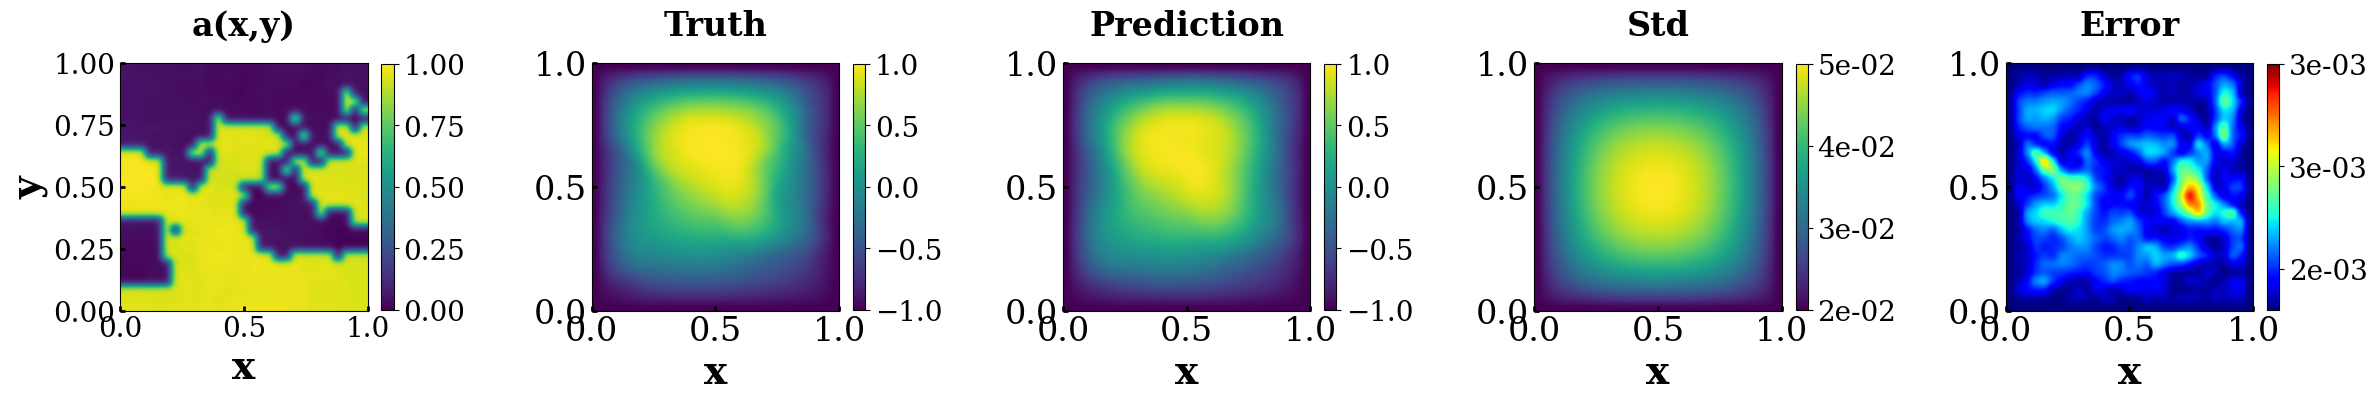

In [19]:
resl = 29  # Update this if the resolution is different

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Assuming index is the example you want to plot
index = 0

# Initial Condition (IC)
axes[0].set_title("a(x,y)", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test[index, :, :], 
    cmap="viridis",
    extent=[0, 1, 0, 1],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(axis='both', labelsize="medium", width=2, direction='in')

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],  # Assuming y_t is correctly shaped
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Model Prediction
axes[2].set_title("Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    SDD_mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :],  # Using loaded mean prediction
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    SDD_std_pred.reshape(SDD_std_pred.shape[0], resl, resl)[index, :, :],  # Using loaded variance prediction
    cmap="viridis",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Prediction Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t.detach().cpu().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - SDD_mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(axis='both', labelsize="large", width=2, direction='in')

plt.tight_layout()
# plt.savefig('/home/user/Documents/WaKeGP/experiments/C5_navier/civ_Row_NS_04_24_8_24.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()


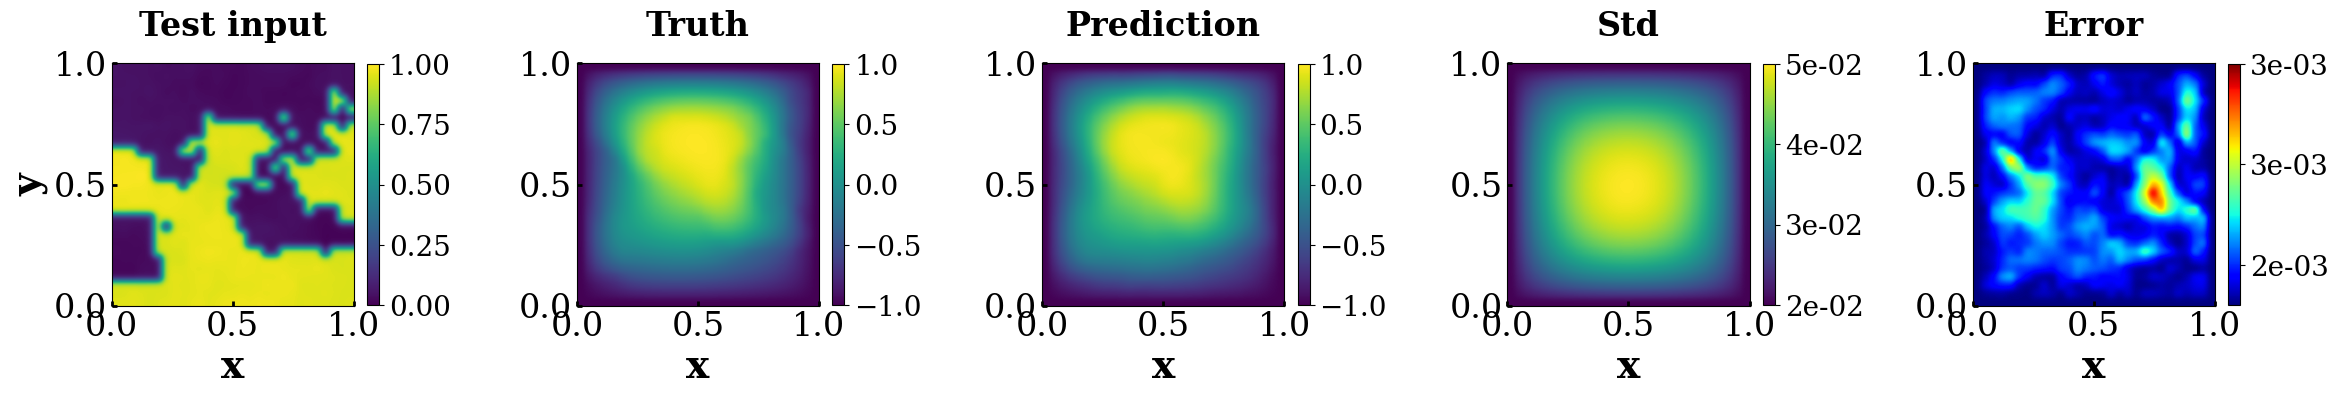

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming resl, x_test_hres, y_t,SDD_mean_pred, SDD_std_pred are already defined
resl = 29

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Define tick parameters
common_tick_params = {
    'axis': 'both', 
    'labelsize': "large", 
    'width': 2, 
    'direction': 'in'
}

# Assuming index is the example you want to plot
index = 0

# Forcing term (IC)
axes[0].set_title("Test input", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test[index, :, :], 
    cmap="viridis",
    extent=[0, 1, 0, 1],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(**common_tick_params)

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(**common_tick_params)

# Model Prediction
axes[2].set_title("Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    SDD_mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(**common_tick_params)

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    SDD_std_pred.reshape(SDD_std_pred.shape[0], resl, resl)[index, :, :],  
    cmap="viridis",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(**common_tick_params)

# Prediction Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t.detach().cpu().reshape(y_t.shape[0], resl, resl)[index, :, :]
        -SDD_mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(**common_tick_params)

plt.tight_layout()
plt.savefig('/home/user/Documents/GPO/experiments/C3_darcy_rect/results/row_Darcy_11_09.pdf',format='pdf',dpi=600,bbox_inches='tight')

plt.show()


In [ ]:
# Simple predictions 

# Load the saved numpy arrays
base_dir = '/home/user/Documents/GPO/experiments/C3_darcy_rect/results/'
# current_time = 'your_saved_timestamp_here'  # Replace with the actual timestamp used when saving

y_pred_sdd_hres = np.load(f'{base_dir}mean_pred_hres_110924_0808.npy')
var_pred_sdd_hres = np.load(f'{base_dir}std_pred_hres_110924_0808.npy')
# SDD_sample_pred = np.load(f'{base_dir}hres_resultsSDD_sample_predictions_130824_1044.npy')
# Assuming resl, x_test, y_t_hres, and x_axis are already defined
y_pred_sdd_hres.shape

(200, 841)

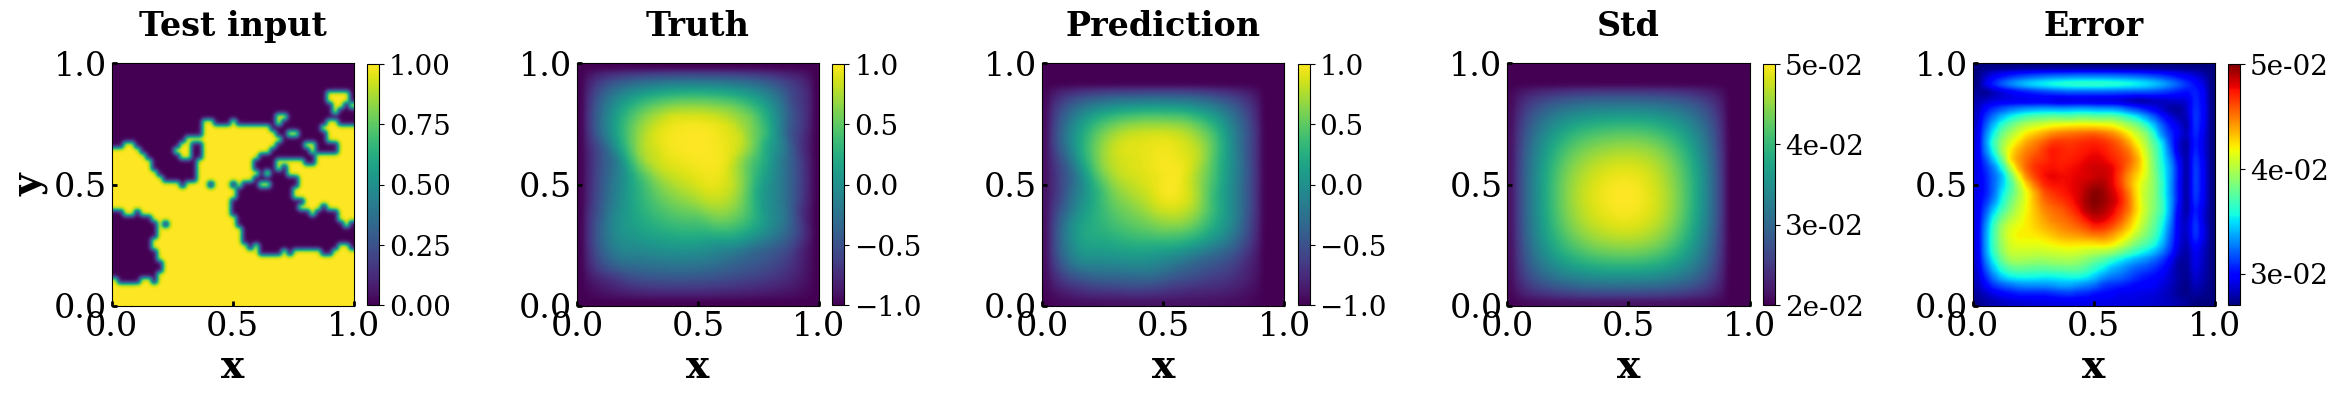

In [ ]:
from matplotlib.cm import ScalarMappable
       
resl = 29

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Assuming index is the example you want to plot
index = 0
# Define tick parameters
# Define tick parameters
common_tick_params = {
    'axis': 'both', 
    'labelsize': "large", 
    'width': 2, 
    'direction': 'in'
}

# BC
axes[0].set_title("Test input", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test_hres[index, :, :],
    cmap="viridis",
    extent=[0, 1, 0, 1],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(**common_tick_params)
# axes[0].tick_params(axis='both', labelsize="medium", width=2, direction='in')
# for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
#     label.set_fontweight('bold')
# True
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
    # vmin=-1,
    # vmax=1,
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(**common_tick_params)
# axes[1].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
#     label.set_fontweight('bold')

# Predictions
axes[2].set_title("Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    y_pred_sdd_hres.reshape(y_pred_sdd_hres.shape[0], resl, resl)[index, :, :],
    origin="lower",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    cmap="viridis",
    # vmin=-1,
    # vmax=1,
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(**common_tick_params)
# axes[2].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[2].get_xticklabels() + axes[2].get_yticklabels():
#     label.set_fontweight('bold')

# Std
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    var_pred_sdd_hres.reshape(var_pred_sdd_hres.shape[0], resl, resl)[index, :, :],
    cmap="viridis",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
    # vmin=0.4,
    # vmax=0.9,
)
sm = ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
# axes[3].set_ylabel("y", fontweight="bold", fontsize=24)
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(**common_tick_params)
# axes[3].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[3].get_xticklabels() + axes[3].get_yticklabels():
#     label.set_fontweight('bold')

# Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - y_pred_sdd_hres.reshape(y_pred_sdd_hres.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 1, 0, 1],
    interpolation="Gaussian",
    origin="lower",
    # vmax=2e-2,
    # vmin=3e-4,
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=5e-2, vmax=3e-2))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(**common_tick_params)
# axes[4].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[4].get_xticklabels() + axes[4].get_yticklabels():
#     label.set_fontweight('bold')

plt.tight_layout()
plt.savefig('/home/user/Documents/GPO/experiments/C3_darcy_rect/results/super_Darcy_11_09.pdf',format='pdf',dpi=600,bbox_inches='tight')
